In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_entropy_curve(image):
    # Calculate the histogram of the image
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    prob = hist / hist.sum()  # Probability of each intensity level
    prob[prob == 0] = 1  # Prevent log(0) by replacing zeros with 1 temporarily

    # Calculate entropy for each intensity level
    entropy_values = -prob * np.log2(prob)
    entropy_values[prob == 1] = 0  # Reset entropy values for zero probabilities to zero
    return entropy_values

def clip_and_slice_entropy_curve(entropy_curve, quantiles=[0.25, 0.5, 0.75]):
    # Clipping the entropy curve based on quantile clipping
    clipping_limit = np.quantile(entropy_curve[entropy_curve > 0], quantiles)
    clipped_entropy_curve = np.minimum(entropy_curve, clipping_limit[-1])

    # Determine slicing thresholds based on standard deviation
    mean_intensity = np.mean(np.nonzero(clipped_entropy_curve))
    std_intensity = np.std(np.nonzero(clipped_entropy_curve))
    lower_threshold = int(max(0, mean_intensity - std_intensity))
    upper_threshold = int(min(255, mean_intensity + std_intensity))

    return clipped_entropy_curve, lower_threshold, upper_threshold

def equalize_entropy_segments(image, clipped_entropy_curve, lower_threshold, upper_threshold):
    # Divide the entropy curve into three segments
    segments = [
        (0, lower_threshold),
        (lower_threshold + 1, upper_threshold),
        (upper_threshold + 1, 255)
    ]

    # Perform histogram equalization on each segment
    equalized_image = np.zeros_like(image)
    for start, end in segments:
        mask = (image >= start) & (image <= end)
        if np.any(mask):
            segment_pixels = image[mask]
            hist, bins = np.histogram(segment_pixels.flatten(), bins=end - start + 1, range=(start, end))
            cdf = hist.cumsum()
            cdf_normalized = cdf * 255 / cdf[-1]  # Normalize to 0-255

            equalized_image[mask] = np.interp(segment_pixels, bins[:-1], cdf_normalized)
    return equalized_image

def entropy_based_contrast_enhancement(image):
    # Convert to grayscale if the image has multiple channels (e.g., is color)
    if len(image.shape) == 3 and image.shape[2] == 3:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale_image = image  # Image is already grayscale

    # Step 1: Compute entropy curve
    entropy_curve = compute_entropy_curve(grayscale_image)

    # Step 2: Clip and slice the entropy curve
    clipped_entropy_curve, lower_thresh, upper_thresh = clip_and_slice_entropy_curve(entropy_curve)

    # Step 3: Equalize the image using the entropy segments
    enhanced_image = equalize_entropy_segments(grayscale_image, clipped_entropy_curve, lower_thresh, upper_thresh)

    return enhanced_image

In [7]:
from skimage import data, img_as_float
image = data.moon()
image.shape

(512, 512)

(-0.5, 511.5, 511.5, -0.5)

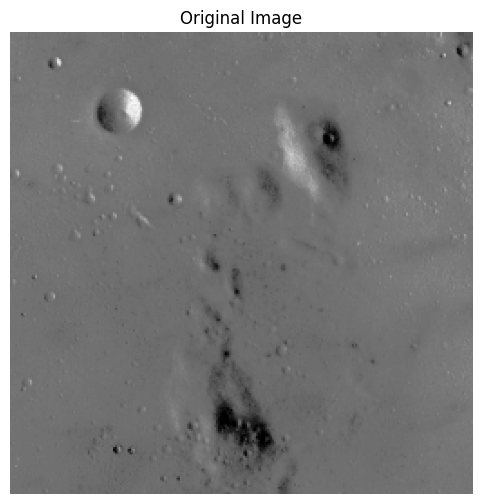

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.title('Original Image')
plt.imshow(image, cmap="gray")
plt.axis('off')

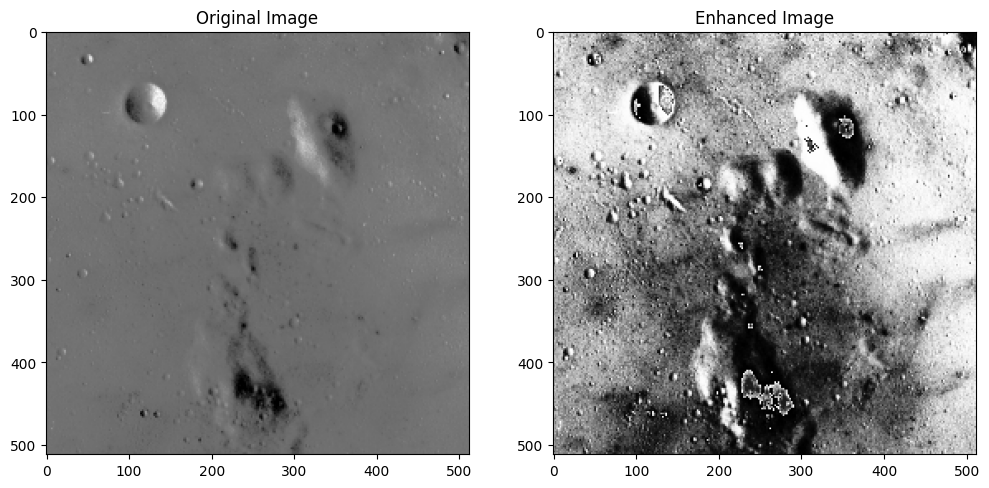

In [9]:
# Apply the entropy-based contrast enhancement
enhanced_image = entropy_based_contrast_enhancement(image)

# Show the original and enhanced images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image, cmap='gray')
plt.show()
